In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, roc_auc_score, f1_score, precision_score, accuracy_score, confusion_matrix, roc_curve
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import numpy as np

In [2]:
sns.set_style("darkgrid")

In [3]:
cc_df = pd.read_csv("data/credit_card_purchases.csv", dtype = {'merch_zipcode': 'str'})
cc_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

Only march_zipcode has missing values about 15%, we will drop that column after creating an indicator missing variable column

In [4]:
cc_df['ind_msg_mzip'] = np.where(cc_df['merch_zipcode'].isnull(), 1, 0)

In [5]:
cc_df = cc_df.drop(['merch_zipcode'], axis = 1)

### Split the Data
We will use the dataset named 'data' for the development and evaluation of our model. Upon deployment of the application, we will leverage the holdout data to generate various datasets for use within the app.

In [6]:
data, holdout = train_test_split(cc_df, test_size=0.22, stratify = cc_df['is_fraud'], random_state=11)

## Feature Engineering

In [7]:
# Converting string date to datetime
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])

In [8]:
# Split the date and the time of the transaction 
data['trans_date'] = data['trans_date_trans_time'].dt.date
data['trans_time'] = data['trans_date_trans_time'].dt.time

In [9]:
# Drop unecessary columns for the EDA and model development
df = data.drop(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'street', 'unix_time','merch_lat', 'merch_long','lat', 'long'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1011406 entries, 1043883 to 733666
Data columns (total 17 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   merchant      1011406 non-null  object 
 1   category      1011406 non-null  object 
 2   amt           1011406 non-null  float64
 3   first         1011406 non-null  object 
 4   last          1011406 non-null  object 
 5   gender        1011406 non-null  object 
 6   city          1011406 non-null  object 
 7   state         1011406 non-null  object 
 8   zip           1011406 non-null  int64  
 9   city_pop      1011406 non-null  int64  
 10  job           1011406 non-null  object 
 11  dob           1011406 non-null  object 
 12  trans_num     1011406 non-null  object 
 13  is_fraud      1011406 non-null  int64  
 14  ind_msg_mzip  1011406 non-null  int64  
 15  trans_date    1011406 non-null  object 
 16  trans_time    1011406 non-null  object 
dtypes: float64(1), int64(4), ob

In [10]:
# create new variables age, day of the week, month and year
df['age'] = ((pd.to_datetime(df['trans_date']) - pd.to_datetime(df['dob'])).dt.days/365).astype(int)
df['day_of_week'] = pd.to_datetime(df['trans_date']).dt.day_name()
df['month'] = pd.to_datetime(df['trans_date']).dt.month
df['year'] = pd.to_datetime(df['trans_date']).dt.year

In [11]:
# Extract hour from the 'trans_time' column
df['hour'] = pd.to_datetime(df['trans_time'], format='%H:%M:%S').dt.hour

In [12]:
# Create the time categories and their corresponding labels
time_bins = [0, 5, 9, 12, 16, 18, 21, 24]
time_labels = ['late night','early morning', 'late morning', 'early afternoon', 'late afternoon', 'evening', 'night']

In [13]:
# Create the 'time_of_day' column based on the time bins and labels
df['time_of_day'] = pd.cut(df['hour'], bins=time_bins, labels=time_labels, right=False)

In [14]:
# Create a new variable 'season' based on the value of 'month'
def month_to_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

df['season'] = df['month'].apply(month_to_season)

In [15]:
# Define age groups
age_bins = [0, 18, 36, 51, 65, 100]
age_labels = ['Under-18', '19-35', '36-50', '51-65','66-plus']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

In [16]:
# Dictionary mapping states to regions
state_to_region = {
    'NY': 'Northeast', 'PA': 'Northeast', 'NJ': 'Northeast', 'CT': 'Northeast', 'MA': 'Northeast', 'RI': 'Northeast', 'VT': 'Northeast', 'NH': 'Northeast', 'ME': 'Northeast',
    'CA': 'West', 'OR': 'West', 'WA': 'West', 'AK': 'West', 'HI': 'West', 'NV': 'West', 'ID': 'West', 'MT': 'West', 'WY': 'West', 'UT': 'West', 'CO': 'West',
    'TX': 'South', 'FL': 'South', 'GA': 'South', 'SC': 'South', 'NC': 'South', 'VA': 'South', 'WV': 'South', 'KY': 'South', 'TN': 'South', 'AL': 'South', 'MS': 'South', 'AR': 'South', 'LA': 'South', 'OK': 'South',
    'IL': 'Midwest', 'IN': 'Midwest', 'OH': 'Midwest', 'MI': 'Midwest', 'WI': 'Midwest', 'MN': 'Midwest', 'IA': 'Midwest', 'MO': 'Midwest', 'ND': 'Midwest', 'SD': 'Midwest', 'NE': 'Midwest', 'KS': 'Midwest',
    'AZ': 'West', 'NM': 'West', 'MD': 'South', 'DC': 'South', 'DE': 'South'
}

In [17]:
# Create the region column based on the state
df['region'] = df['state'].map(state_to_region)

In [18]:
# Drop unecessary columns for the EDA and model development
df = df.drop(['merchant', 'first', 'last', 'zip', 'dob', 'trans_date', 'trans_time', 'hour', 'city', 'state', 'age', 'year', 'month', 'job'], axis = 1)
df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Index: 1011406 entries, 1043883 to 733666
Data columns (total 12 columns):
 #   Column        Non-Null Count    Dtype   
---  ------        --------------    -----   
 0   category      1011406 non-null  object  
 1   amt           1011406 non-null  float64 
 2   gender        1011406 non-null  object  
 3   city_pop      1011406 non-null  int64   
 4   trans_num     1011406 non-null  object  
 5   is_fraud      1011406 non-null  int64   
 6   ind_msg_mzip  1011406 non-null  int64   
 7   day_of_week   1011406 non-null  object  
 8   time_of_day   1011406 non-null  category
 9   season        1011406 non-null  object  
 10  age_group     1011406 non-null  category
 11  region        1011406 non-null  object  
dtypes: category(2), float64(1), int64(3), object(6)
memory usage: 86.8+ MB


In [19]:
df.to_csv('MLOps/fraud_data.csv', index = False)

## Exploratory Data Analysis

In [20]:
# Split the data into fraud and non-fraud
fraud_data = df[df['is_fraud'] == 1]
non_fraud_data = df[df['is_fraud'] == 0]

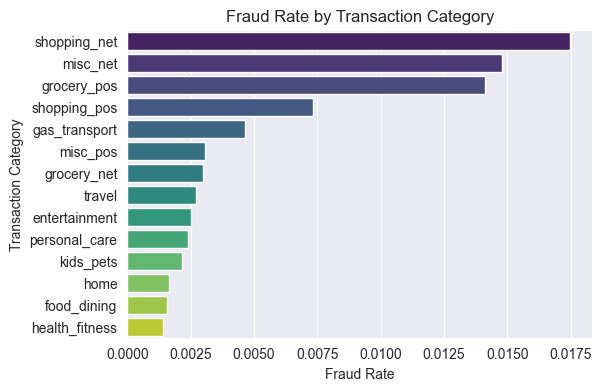

In [21]:
# Calculate the fraud rate for each transaction category
category_fraud_rate = df.groupby('category')['is_fraud'].mean().sort_values(ascending=False)

# Plotting the fraud rate by transaction category
plt.figure(figsize=(6, 4))
sns.barplot(x=category_fraud_rate, y=category_fraud_rate.index, hue = category_fraud_rate.index, palette='viridis')
plt.title('Fraud Rate by Transaction Category')
plt.xlabel('Fraud Rate')
plt.ylabel('Transaction Category')
plt.show()

### Fraud Rates by Transaction Category

The bar chart above illustrates the fraud rates for different transaction categories. Key insights include:

- Some categories have notably higher fraud rates compared to others.
- Categories like `grocery_pos`, `misc_net`, and `shopping_net` show relatively higher fraud rates.
- On the other hand, categories such as `health_fitness` and `food_dining` have lower fraud rates.

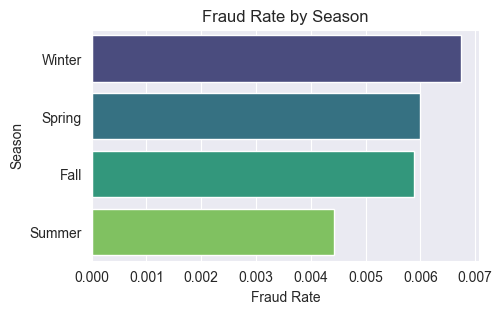

In [22]:
# Calculate the fraud rate for each season
season_fraud_rate = df.groupby('season')['is_fraud'].mean().sort_values(ascending=False)

# Plotting the fraud rate by season
plt.figure(figsize=(5, 3))
sns.barplot(x=season_fraud_rate, y=season_fraud_rate.index, hue = season_fraud_rate.index, palette='viridis')
plt.title('Fraud Rate by Season')
plt.xlabel('Fraud Rate')
plt.ylabel('Season')
plt.show()


### Fraud Rates by Season

Key observations:

- The highest fraud rates are observed in the Winter.
- Summer has comparatively lower fraud rates.

These seasonal variations can be crucial for implementing seasonal-specific fraud detection strategies, focusing more on periods with higher fraud rates.

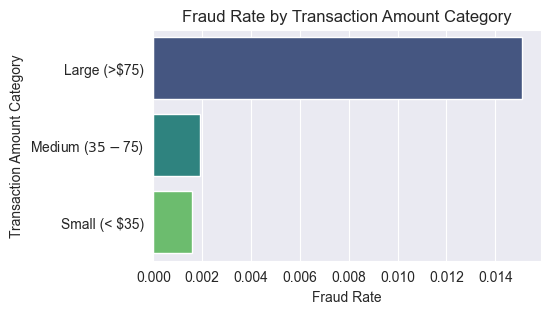

In [23]:
# Create a function to categorize transaction amounts
def categorize_amount(amount):
    if amount < 10:
        return 'Small (< $35)'
    elif amount <= 75:
        return 'Medium ($35 - $75)'
    else:
        return 'Large (>$75)'

# Apply the categorization function to the 'amt' column
df['amt_category'] = df['amt'].apply(categorize_amount)

# Calculate the fraud rate for each transaction amount category
amt_fraud_rate = df.groupby('amt_category')['is_fraud'].mean().sort_values(ascending=False)

# Plotting the fraud rate by transaction amount category
plt.figure(figsize=(5, 3))
sns.barplot(x=amt_fraud_rate, y=amt_fraud_rate.index, hue = amt_fraud_rate.index, palette='viridis')
plt.title('Fraud Rate by Transaction Amount Category')
plt.xlabel('Fraud Rate')
plt.ylabel('Transaction Amount Category')
plt.show()


### Fraud Rates by Transaction Amount Category

Key insights include:

- We observe the highest fraud rate with Large amount transactions.
- Medium and Small amount transactions have relatively very small fraud rate.

This trend suggests that higher transaction amounts are more susceptible to fraud. This insight is critical for implementing stricter fraud detection measures on higher-value transactions to mitigate risk.

In [24]:
fraud_data1 = df[df['is_fraud'] == 1]
non_fraud_data1 = df[df['is_fraud'] == 0]

In [25]:
fraud_data1['amt'].describe(), non_fraud_data1['amt'].describe()

(count    5855.000000
 mean      534.236799
 std       389.920962
 min         1.060000
 25%       254.570000
 50%       425.000000
 75%       902.270000
 max      1376.040000
 Name: amt, dtype: float64,
 count    1.005551e+06
 mean     6.769855e+01
 std      1.557940e+02
 min      1.000000e+00
 25%      9.600000e+00
 50%      4.728000e+01
 75%      8.253000e+01
 max      2.894890e+04
 Name: amt, dtype: float64)

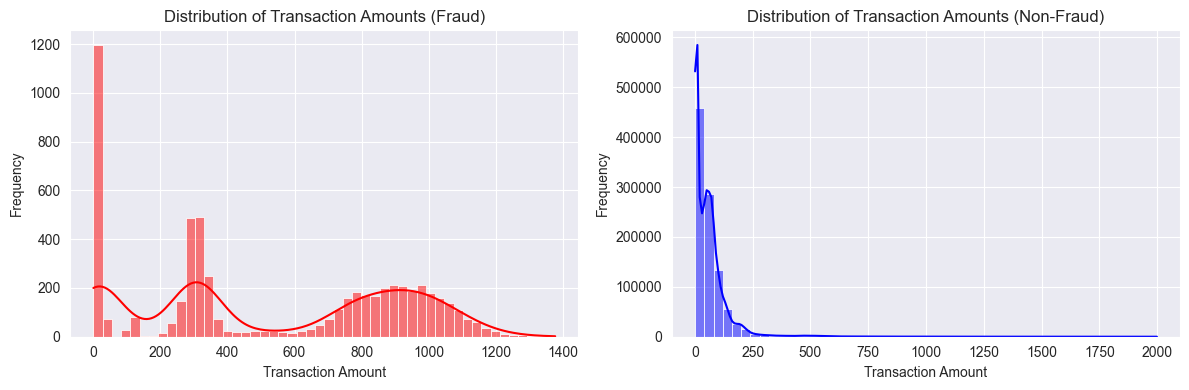

In [26]:
# Filter the data to exclude transactions with amounts greater than 2000
filtered_data = df[df['amt'] <= 2000]

# Split the filtered data into fraud and non-fraud
fraud_data = filtered_data[filtered_data['is_fraud'] == 1]
non_fraud_data = filtered_data[filtered_data['is_fraud'] == 0]

# Plotting the distribution of transaction amounts for fraud and non-fraud
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(fraud_data['amt'], bins=50, kde=True, ax=ax[0], color='red')
ax[0].set_title('Distribution of Transaction Amounts (Fraud)')
ax[0].set_xlabel('Transaction Amount')
ax[0].set_ylabel('Frequency')

sns.histplot(non_fraud_data['amt'], bins=50, kde=True, ax=ax[1], color='blue')
ax[1].set_title('Distribution of Transaction Amounts (Non-Fraud)')
ax[1].set_xlabel('Transaction Amount')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Distribution of Transaction Amounts for Fraud and Non-Fraud Transactions

Key findings:
- The distribution of transaction amounts for non-fraudulent transactions shows a higher concentration of smaller amounts, then fall off after $250. In the other hand for fraud transactions the amount is more spread.  
- The mean amount for fraudulent transaction is 534.24 while the mean amount for non-fraudlent transaction is 67.7 

**Key Takeaways**:
- Both fraud and non-fraud transactions are more frequent at lower amounts.
- Non-Fraudulent transactions have a sharper decline in frequency as the transaction amount increases compared to fraudulent transactions. 

These insights can be useful in identifying patterns and anomalies in transaction amounts that may indicate fraudulent behavior.

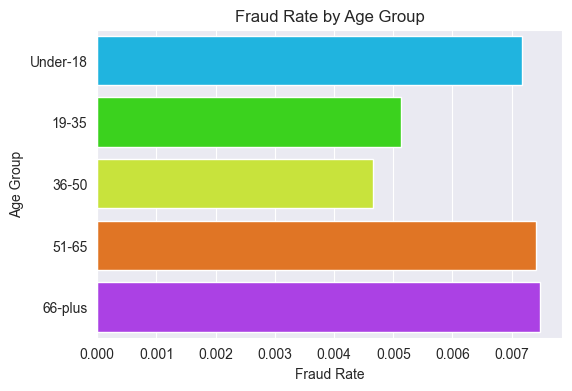

In [27]:
# Calculate the fraud rate for each age group
age_group_fraud_rate = df.groupby('age_group', observed=True)['is_fraud'].mean()

# Plotting the fraud rate by age group
plt.figure(figsize=(6, 4))
sns.barplot(x=age_group_fraud_rate, y=age_group_fraud_rate.index, hue=age_group_fraud_rate.index, palette='gist_ncar')
plt.title('Fraud Rate by Age Group')
plt.xlabel('Fraud Rate')
plt.ylabel('Age Group')
plt.show()

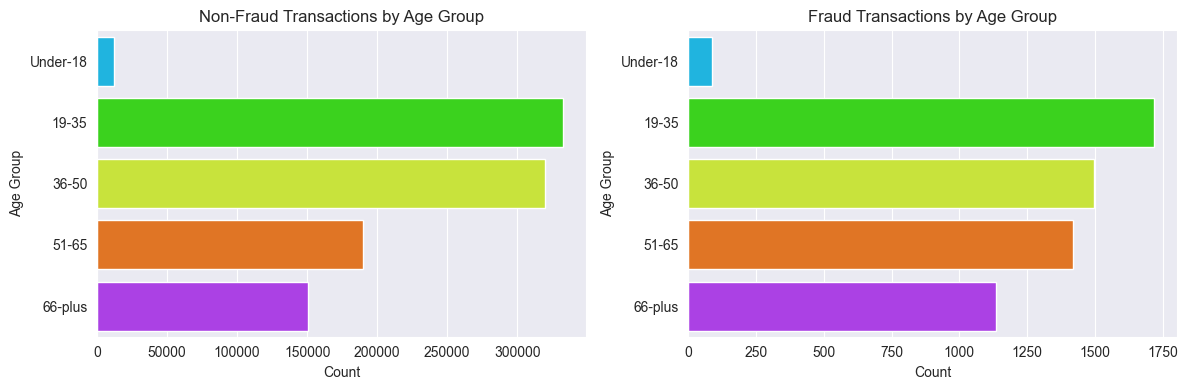

In [28]:
# Plot Age Group
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(y='age_group', data=non_fraud_data, ax=ax[0], order=['Under-18', '19-35', '36-50', '51-65', '66-plus'], hue='age_group', palette='gist_ncar', legend=False)
ax[0].set_title('Non-Fraud Transactions by Age Group')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('Age Group')

sns.countplot(y='age_group', data=fraud_data, ax=ax[1], order=['Under-18', '19-35', '36-50', '51-65', '66-plus'], hue='age_group', palette='gist_ncar', legend=False)
ax[1].set_title('Fraud Transactions by Age Group')
ax[1].set_xlabel('Count')
ax[1].set_ylabel('Age Group')

plt.tight_layout()
plt.show()


### Fraud by Age Group

The three bar charts above illustrate that both the fraud rates and number of fraudlent transaction for different age groups. Key insights include:

- The fraud rate is relatively lower in the age groups 19-35 and 36-50.
- By the number of transactions we observe more transaction between the ages of 19 to 50.

The key metric to focus on in the age group is fraud rate.

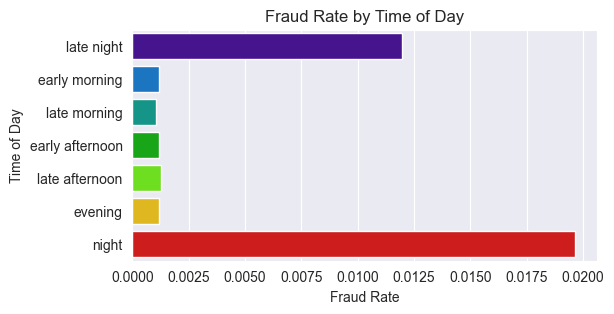

In [30]:
# Calculate the fraud rate for each time of day
time_of_day_fraud_rate = df.groupby('time_of_day', observed=True )['is_fraud'].mean().sort_values(ascending=False)

# Plotting the fraud rate by time of day
plt.figure(figsize=(6, 3))
sns.barplot(x=time_of_day_fraud_rate, y=time_of_day_fraud_rate.index, hue=time_of_day_fraud_rate.index, palette='nipy_spectral')
plt.title('Fraud Rate by Time of Day')
plt.xlabel('Fraud Rate')
plt.ylabel('Time of Day')
plt.show()

### Fraud rate by the Time of Day

Fraud rates are higher during late night and late night hours, indicating a potential pattern of fraudulent activities during these times.

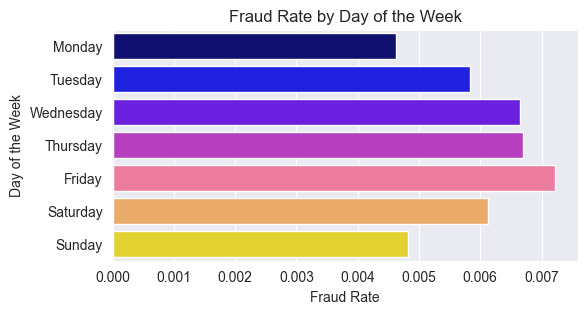

In [31]:
# Set the order of days for consistent plotting
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Calculate the fraud rate for each day of the week
day_of_week_fraud_rate = df.groupby('day_of_week', observed=True)['is_fraud'].mean().reindex(day_order)

# Plotting the fraud rate by day of the week
plt.figure(figsize=(6, 3))
sns.barplot(x=day_of_week_fraud_rate, y=day_of_week_fraud_rate.index, hue=day_of_week_fraud_rate.index, palette='gnuplot2')
plt.title('Fraud Rate by Day of the Week')
plt.xlabel('Fraud Rate')
plt.ylabel('Day of the Week')
plt.show()

We have lower fraud rate Sundays and Mondays

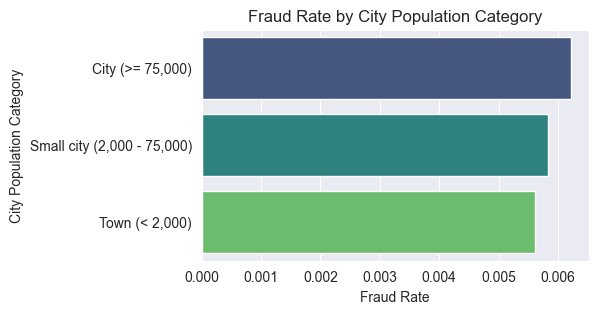

In [32]:
# Create a function to categorize city population
def categorize_city_pop(pop):
    if pop < 2000:
        return 'Town (< 2,000)'
    elif pop < 75000:
        return 'Small city (2,000 - 75,000)'
    #elif pop < 100000:
        #return 'Large (30,000 - 100,000)'
    else:
        return 'City (>= 75,000)'

# Apply the categorization function to the 'city_pop' column
df['city_pop_category'] = df['city_pop'].apply(categorize_city_pop)

# Calculate the fraud rate for each city population category
city_pop_fraud_rate = df.groupby('city_pop_category')['is_fraud'].mean().sort_values(ascending=False)

# Plotting the fraud rate by city population category
plt.figure(figsize=(5, 3))
sns.barplot(x=city_pop_fraud_rate, y=city_pop_fraud_rate.index, hue=city_pop_fraud_rate.index, palette='viridis')
plt.title('Fraud Rate by City Population Category')
plt.xlabel('Fraud Rate')
plt.ylabel('City Population Category')
plt.show()


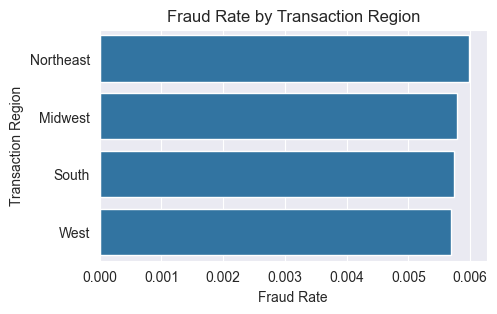

In [33]:
# Calculate the fraud rate for each region
region_fraud_rate = df.groupby('region')['is_fraud'].mean().sort_values(ascending=False)

# Plotting the fraud rate by region
plt.figure(figsize=(5, 3))
sns.barplot(x=region_fraud_rate, y=region_fraud_rate.index)
plt.title('Fraud Rate by Transaction Region')
plt.xlabel('Fraud Rate')
plt.ylabel('Transaction Region')
plt.show()


# Modeling

We will train six distinct models and select the one with the highest performance for deployment. Given the class imbalance in the dependent variable 'is_fraud', we will use the recall score as our primary metric for model selection. This prioritizes minimizing false negatives, which is crucial in fraud detection scenarios.

In [34]:
# Define feature columns and target column
X = df.drop(columns=['is_fraud', 'trans_num'])
y = df['is_fraud']

In [35]:
# Define the ordinal categories
day_of_week_categories = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
time_of_day_categories = ['late night', 'early morning', 'late morning', 'early afternoon', 'late afternoon', 'evening', 'night']
season_categories = ['Spring', 'Summer', 'Fall', 'Winter']
age_group_categories = ['Under-18', '19-35', '36-50', '51-65', '66-plus']

In [36]:
# Preprocessing pipeline for numerical features
numerical_features = ['amt', 'city_pop']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


In [37]:
# Preprocessing pipeline for categorical features
categorical_features = ['category', 'gender', 'region']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [38]:
# Preprocessing pipeline for ordinal features
ordinal_features = ['day_of_week', 'time_of_day', 'season', 'age_group']
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[day_of_week_categories, time_of_day_categories, season_categories, age_group_categories]))
])

In [39]:
# Combine preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)
    ])

In [40]:
# Models to evaluate
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(),
    'BaggingClassifier': BaggingClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'NaiveBayes': GaussianNB(),
    'GradientBoosting': GradientBoostingClassifier()
}

In [41]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11, stratify=y)

In [42]:
# Balance the dataset using RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

In [43]:
# Function to train and evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    return recall, auc, f1, precision, accuracy, y_pred, y_prob, pipeline #, (fpr, tpr)

In [44]:
# Evaluate all models
results = {}
for model_name, model in models.items():
    recall, auc, f1, precision, accuracy, y_pred, y_prob, pipeline = evaluate_model(model, X_train_resampled, y_train_resampled, X_test, y_test)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    results[model_name] = {
        'recall': recall,
        'auc': auc,
        'f1': f1,
        'precision': precision,
        'accuracy': accuracy,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'pipeline': pipeline,
        'confusion_matrix': cm,
        'roc_curve': (fpr, tpr)
        
    }

In [45]:
# Print evaluation metrics for all models
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print("\n")

Model: LogisticRegression
Recall: 0.7649
AUC: 0.9174
F1 Score: 0.0691
Precision: 0.0362
Accuracy: 0.8807


Model: RandomForest
Recall: 0.8088
AUC: 0.9871
F1 Score: 0.8665
Precision: 0.9330
Accuracy: 0.9986


Model: BaggingClassifier
Recall: 0.8093
AUC: 0.9517
F1 Score: 0.8372
Precision: 0.8671
Accuracy: 0.9982


Model: DecisionTree
Recall: 0.7923
AUC: 0.8956
F1 Score: 0.8042
Precision: 0.8164
Accuracy: 0.9978


Model: NaiveBayes
Recall: 0.7336
AUC: 0.8195
F1 Score: 0.0248
Precision: 0.0126
Accuracy: 0.6652


Model: GradientBoosting
Recall: 0.9596
AUC: 0.9939
F1 Score: 0.2751
Precision: 0.1606
Accuracy: 0.9707




In [46]:
# Select the top 3 models based on recall
top_models = sorted(results.items(), key=lambda item: item[1]['recall'], reverse=True)[:3]


Model: GradientBoosting
Recall: 0.9596
AUC: 0.9939
F1 Score: 0.2751
Precision: 0.1606
Accuracy: 0.9707


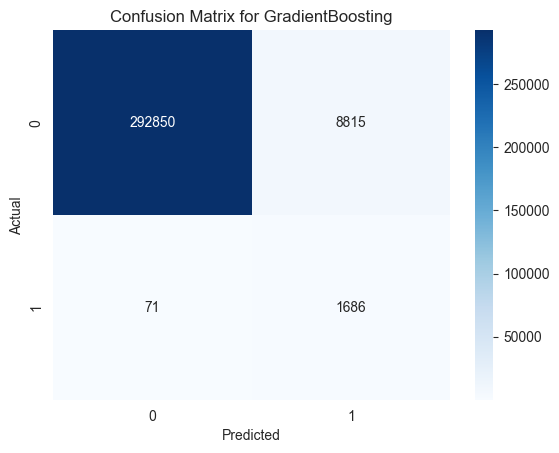

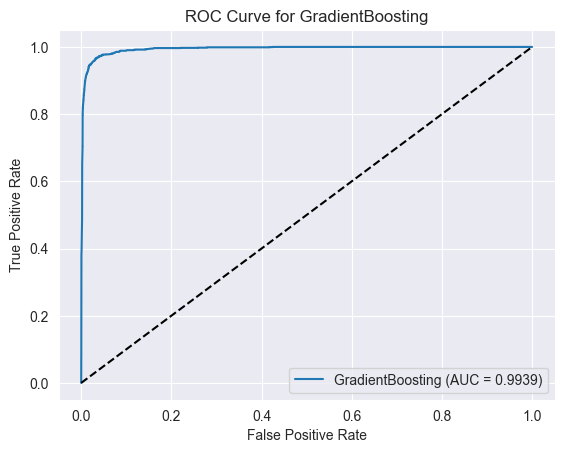


Model: BaggingClassifier
Recall: 0.8093
AUC: 0.9517
F1 Score: 0.8372
Precision: 0.8671
Accuracy: 0.9982


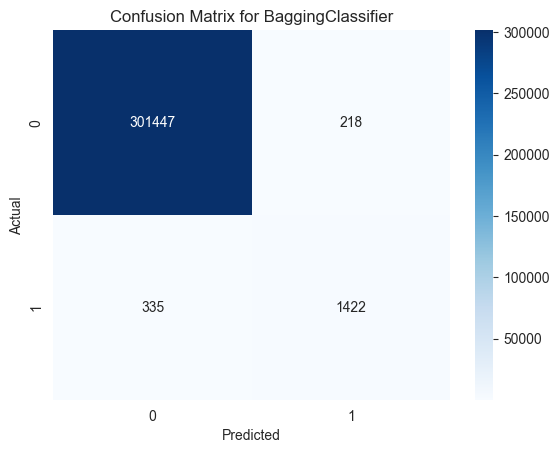

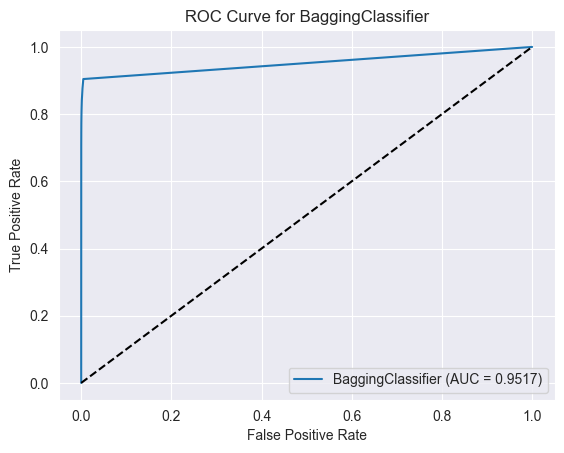


Model: RandomForest
Recall: 0.8088
AUC: 0.9871
F1 Score: 0.8665
Precision: 0.9330
Accuracy: 0.9986


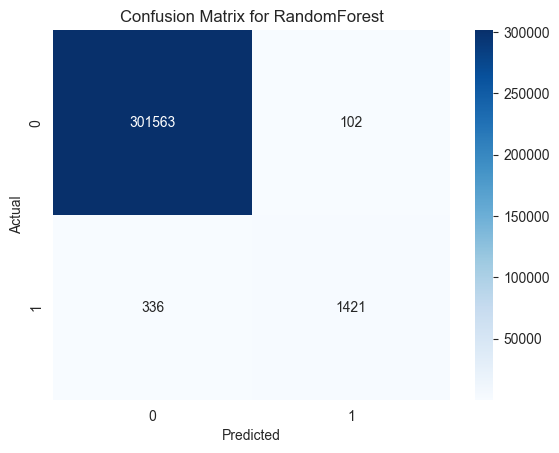

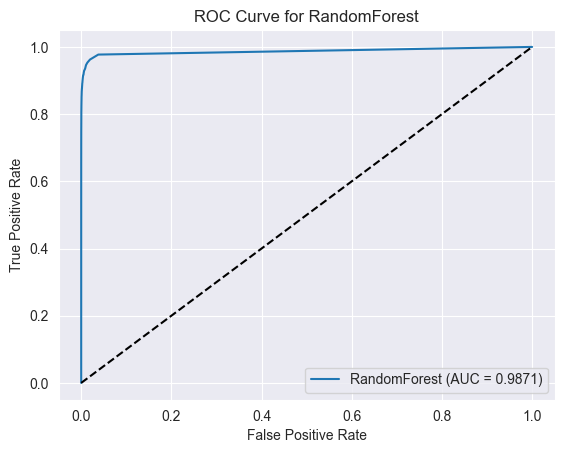

In [47]:
# Display the results of the top 3 models
for model_name, metrics in top_models:
    print(f"\nModel: {model_name}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    #print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")
    
    # Plot confusion matrix
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Plot ROC curve
    fpr, tpr, _ = metrics['roc_curve'] if len(metrics['roc_curve']) == 3 else (metrics['roc_curve'][0], metrics['roc_curve'][1], None)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {metrics["auc"]:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='best')
    plt.show()

### Best Model 

The best model is the Gradient Boosting Classifier with a recall score of 95.96%, and we will use it for model deployment